# Detect multi unit events

    Multiunit High Synchrony Event detector. Finds times when the multiunit
    population spiking activity is high relative to the average.

In [1]:
from ripple_detection import multiunit_HSE_detector
import os
import h5py
import pickle
import pandas as pd
import numpy as np
import hdf5storage
from matplotlib import pyplot as plt
import glob
import itertools
import multiprocessing
from joblib import Parallel, delayed
from ripple_detection.core import get_multiunit_population_firing_rate
from scipy.signal import find_peaks,peak_prominences
from scipy.stats import norm


Bad key "text.kerning_factor" on line 4 in
D:\ryanh\Anaconda3\envs\ripple_analysis\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
def load_position(session):
    f = h5py.File(session,'r')
    # load frames [ts x y a s] 
    frames = np.transpose(np.array(f['frames']))
    return pd.DataFrame(frames,columns=['ts', 'x', 'y', 'hd', 'speed'])   

def get_session_path(session):
    f = h5py.File(session,'r')
    return f['session_path'][()].tobytes()[::2].decode()

def get_spikes(filename):
    data = hdf5storage.loadmat(filename,variable_names=['Spikes'])
    spike_times=data['Spikes']
    spike_times=np.squeeze(spike_times)
    for i in range(spike_times.shape[0]):
        spike_times[i]=np.squeeze(spike_times[i])
    return spike_times

def bin_spikes(spike_times,dt,wdw_start,wdw_end):
    """
    Function that puts spikes into bins
    Parameters
    ----------
    spike_times: an array of arrays
        an array of neurons. within each neuron's array is an array containing all the spike times of that neuron
    dt: number (any format)
        size of time bins
    wdw_start: number (any format)
        the start time for putting spikes in bins
    wdw_end: number (any format)
        the end time for putting spikes in bins
    Returns
    -------
    neural_data: a matrix of size "number of time bins" x "number of neurons"
        the number of spikes in each time bin for each neuron
    """
    edges=np.arange(wdw_start,wdw_end,dt) #Get edges of time bins
    num_bins=edges.shape[0]-1 #Number of bins
    num_neurons=spike_times.shape[0] #Number of neurons
    neural_data=np.empty([num_bins,num_neurons]) #Initialize array for binned neural data
    #Count number of spikes in each bin for each neuron, and put in array
    for i in range(num_neurons):
        neural_data[:,i]=np.histogram(spike_times[i],edges)[0]
    return neural_data

def get_peak_ts(high_synchrony_event_times,firing_rate,ts):
    peak_ts = []
    for event in high_synchrony_event_times.itertuples():
        idx = (ts >= event.start_time) & (ts <= event.end_time)
        temp_ts = ts[idx]
        peak_ts.append(temp_ts[np.argmax(firing_rate[idx])])
    return peak_ts

def fastrms(x,window=5):
    window = np.ones(window)
    power = x**2
    rms = np.convolve(power,window,mode='same')
    return  np.sqrt(rms/sum(window));
    
def get_place_fields(ratemap,min_peak_rate=2,min_field_width=2,max_field_width=39,percent_threshold=0.2):
    
    std_rates = np.std(ratemap)
    
    locs,properties = find_peaks(fastrms(ratemap), height=min_peak_rate, width=min_field_width)
    pks = properties['peak_heights']

    exclude = []
    for j in range(len(locs)-1):
        if min(ratemap[locs[j]:locs[j+1]]) > ((pks[j] + pks[j+1]) / 2) * percent_threshold:
            if pks[j] > pks[j+1]:
                exclude.append(j+1)
            elif pks[j] < pks[j+1]:
                exclude.append(j)
       
    if any(ratemap[locs] < std_rates*.5):
        exclude.append(np.where(ratemap[locs] < std_rates*.5))
    if not exclude:
        pks = np.delete(pks, exclude)
        locs = np.delete(locs, exclude)
    
    fields = []
    for j in range(len(locs)):
        Map_Field = (ratemap > pks[j] * percent_threshold)*1;
        start = locs[j]
        stop = locs[j]
        
        while (Map_Field[start] == 1)  & (start > 0):
            start -= 1
        while (Map_Field[stop] == 1)  & (stop < len(Map_Field)-1):
            stop += 1

        if ((stop - start) > min_field_width) & ((stop - start) < max_field_width):
            com = start
            while sum(ratemap[start:stop]) - sum(ratemap[start:com]) > sum(ratemap[start:com])/2:
                com += 1
            fields.append((start,stop,stop - start,pks[j],locs[j],com))
                        
    # add to data frames
    fields = pd.DataFrame(fields, columns=("start", "stop", "width", "peakFR", "peakLoc", "COM"))   
    
    # remove fields with the same field boundaries and keep the one with the highest peak rate
    fields = fields.sort_values(by=['peakFR'],ascending=False)
    fields.drop_duplicates(subset = ['start', 'stop'])

    return fields

def get_place_cell_idx(session):
    """
    find cells to include. At least 1 field from both directions
    """
    data = hdf5storage.loadmat(session,variable_names=['ratemap'])
    include = []
    field = 0
    for i in range(data['ratemap'].shape[0]):
        for d in range(2):
            fields = get_place_fields(data['ratemap'][i,d][0])
            if not fields.empty:
                field += 1
        if field > 0:
            include.append(1)
        else:
            include.append(0)
        field = 0
    return include    

In [3]:
def run_all(session,dt=0.001):
    
    # get data session path from mat file
    path = get_session_path(session)
    
    # load position data from .mat file
    df = load_position(session)
    
    # load spikes
    spike_times = get_spikes(session)
    
    # bin spikes into single vector
    st = list(itertools.chain.from_iterable(spike_times))
    multiunit, _ = np.histogram(st,bins=np.arange(0, max(st), dt))
    
    # timestamps for binned spikes
    ts = np.arange(0 + dt/2, max(st) - dt/2, dt)
    
    # interp speed of the animal
    speed = np.interp(ts,df.ts,df.speed)
    speed[np.isnan(speed)] = 0
    
    # detect ripples
    high_synchrony_event_times = multiunit_HSE_detector(ts, np.expand_dims(multiunit, axis=1), speed, 1/dt)

    # add peak time stamp
    firing_rate = get_multiunit_population_firing_rate(np.expand_dims(multiunit, axis=1), 1/dt, 0.015)
    peak_time = get_peak_ts(high_synchrony_event_times,firing_rate,ts)
    high_synchrony_event_times['peak_time'] = peak_time
    
    # add duration
    high_synchrony_event_times["ripple_duration"] = high_synchrony_event_times.end_time - high_synchrony_event_times.start_time  
    
    return high_synchrony_event_times

# Run through all sessions and save results

In [4]:
def main_loop(session,data_path,save_path):
    base = os.path.basename(session)
    os.path.splitext(base)
    save_file = save_path + os.path.splitext(base)[0] + '.pkl'
    
    # check if saved file exists
    if os.path.exists(save_file):
        return
        
    # detect ripples and calc some features
    high_synchrony_event_times = run_all(session)   

    # save file
    with open(save_file, 'wb') as f:
        pickle.dump(high_synchrony_event_times, f)


data_path = 'F:\\Projects\\PAE_PlaceCell\\ProcessedData\\'
save_path = "F:\\Projects\\PAE_PlaceCell\\analysis\\multiunit_data\\"

# find HPC sessions
df_sessions = pd.read_csv('D:/ryanh/github/harvey_et_al_2020/Rdata_pae_track_cylinder_all_cells.csv')
sessions = pd.unique(df_sessions.session)
sessions = data_path+sessions

# for session in sessions:
#     print(session)
#     main_loop(session,data_path,save_path)
 
num_cores = multiprocessing.cpu_count()         
processed_list = Parallel(n_jobs=num_cores)(delayed(main_loop)(session,data_path,save_path) for session in sessions)


# Load all events into single data frame

In [5]:
save_path = "F:/Projects/PAE_PlaceCell/analysis/multiunit_data/"
sessions = glob.glob(save_path + '*.pkl')

df=pd.DataFrame()
for session in sessions:
    with open(session, 'rb') as f:
        high_synchrony_event_times = pickle.load(f)
   
    # add data frame of ripple features and add session id
    base = os.path.basename(session)
    high_synchrony_event_times['session'] = os.path.splitext(base)[0]
    df = df.append(high_synchrony_event_times,ignore_index=True)

print(df)

       start_time   end_time  peak_time  ripple_duration  \
0         64.0895    64.3285    64.2555            0.239   
1         69.6875    69.8525    69.7725            0.165   
2         75.6615    75.7805    75.7065            0.119   
3         76.6735    76.8635    76.7755            0.190   
4         82.6235    82.7045    82.6595            0.081   
...           ...        ...        ...              ...   
53669   1474.8415  1475.0365  1474.9495            0.195   
53670   1517.8405  1517.9865  1517.9345            0.146   
53671   1517.9935  1518.2105  1518.1185            0.217   
53672   1532.9235  1532.9785  1532.9515            0.055   
53673   1538.7055  1538.8835  1538.8165            0.178   

                       session  
0      LEM3116_S20180715121821  
1      LEM3116_S20180715121821  
2      LEM3116_S20180715121821  
3      LEM3116_S20180715121821  
4      LEM3116_S20180715121821  
...                        ...  
53669     RH16_S20161207130000  
53670     RH16_

# Add epoch type to data frame

In [ ]:

data_path = 'F:\\Projects\\PAE_PlaceCell\\ProcessedData\\'
dicts = {}
for session in df.session:
    f = h5py.File(data_path+session+'.mat','r')
    ex_ep = []
    for i in range(f['events'].shape[0]):
        ex_ep.append(f['events'][i])
    dicts[session] = ex_ep
    
ep_type = ['pedestal_1','track','pedestal_2','cylinder_1','pedestal_3','cylinder_2','pedestal_4']
df['ep_type'] = np.ones_like(df.session)
# session_df=pd.DataFrame()
for session in np.unique(df.session):
    # stack epoch times
    b = np.hstack(dicts[session])
    
    # add 0 to start to indicate the start of the recording session
    b = np.insert(b,0,0)
    
    # add the ts of the last ripple of the session to indicate end of session
    b = list(b)
    last_rip = max(df.end_time[df.session == session])
    if b[-1] < last_rip:
        b.append(last_rip)
    
    # loop through each epoch and label each ripple
    for ep in range(len(b)-1):
        idx = (df.session == session) & (df.peak_time >= b[ep]) & (df.peak_time <= b[ep+1])
        df['ep_type'][idx] = ep_type[ep]

df

# add group 

In [7]:
# add group
control=('RH13','RH14','LS21','LS23','LE2821','LE2823','LEM3116','LEM3120','LEM3216')
pae=('RH11','RH16','LS17','LS19','LE2813','LEM3124','LEM3206','LEM3246')

df['group'] = np.ones_like(df.session)

regstr = '|'.join(control)
idx = df['session'].str.upper().str.contains(regstr)    
df.group[idx] = 'control'

regstr = '|'.join(pae)
idx = df['session'].str.upper().str.contains(regstr)    
df.group[idx] = 'pae'

<ipython-input-7-fac2c67c4f51>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.group[idx] = 'control'
<ipython-input-7-fac2c67c4f51>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.group[idx] = 'pae'


### add rat id

In [8]:
rat = [s.split('_')[0] for s in df.session]
df['rat']=rat

# Save data frame

In [10]:
os.mkdir(save_path+'post_processed')
df.to_csv(save_path+'post_processed/mua_df.csv')

## below are sections to test the above sections

In [9]:
data_path = 'F:\\Projects\\PAE_PlaceCell\\ProcessedData\\'
save_path = "F:/Projects/PAE_PlaceCell/analysis/multiunit_data/"
if not os.path.exists(save_path):
    os.mkdir(save_path)

df_sessions = pd.read_csv('D:/ryanh/github/harvey_et_al_2020/Rdata_pae_track_cylinder_all_cells.csv')
sessions = pd.unique(df_sessions.session)
sessions = data_path+sessions

session = sessions[10]

# get data session path from mat file
path = get_session_path(session)

# load position data from .mat file
df = load_position(session)

spike_times = get_spikes(session)

# get place cells
include = get_place_cell_idx(session)

In [150]:
from scipy.ndimage import gaussian_filter1d
import itertools

dt = 0.001

# bin spikes into single vector
st = list(itertools.chain.from_iterable(spike_times))
multiunit, _ = np.histogram(st,bins=np.arange(0, max(st), dt))

# timestamps for binned spikes
ts = np.arange(0 + dt/2, max(st) - dt/2, dt)

# interp speed of the animal
speed = np.interp(ts,df.ts,df.speed)
speed[np.isnan(speed)] = 0

# detect ripples
high_synchrony_event_times = multiunit_HSE_detector(ts, np.expand_dims(multiunit, axis=1), speed, 1/dt)
firing_rate = get_multiunit_population_firing_rate(np.expand_dims(multiunit, axis=1), 1/dt, 0.015)

high_synchrony_event_times


def get_n_events(dt,smoothing_sigma=0.015):

    st = list(itertools.chain.from_iterable(spike_times))
    multiunit, _ = np.histogram(st,bins=np.arange(min(df.ts), max(df.ts), dt))

    ts = np.arange(min(df.ts) + dt/2, max(df.ts) - dt/2, dt)

    # interp speed of the animal
    speed = np.interp(ts,df.ts,df.speed)
    speed[np.isnan(speed)] = 0

    # detect ripples
    high_synchrony_event_times = multiunit_HSE_detector(ts, np.expand_dims(multiunit, axis=1), speed, 1/dt, smoothing_sigma=0.015)

    return len(high_synchrony_event_times)

# lengths = [get_n_events(dt) for dt in np.arange(.001,.100,.001)]
# # lengths = []
# # for dt in np.arange(.001,.02,.001):
# #     for ss in np.arange(0,.05,.01):
# #         lengths.append(get_n_events(dt,smoothing_sigma=ss))

# plt.plot(np.arange(.001,.100,.001),lengths)
# plt.show()
# print(np.arange(.001,.100,.001)[np.argmax(lengths)])

Text(0.5, 0, 'time')

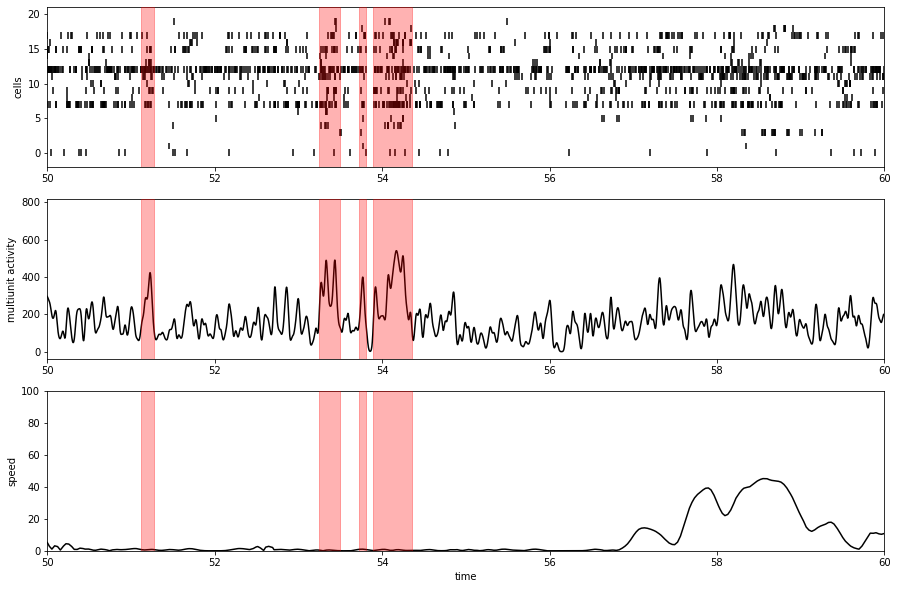

In [153]:
fig, ax = plt.subplots(3,1,figsize=(15, 10))

xlims = [50,60]

ax[0].eventplot(spike_times,color='k')
ax[0].set_ylabel('cells')
for ripple in high_synchrony_event_times.itertuples():
    ax[0].axvspan(ripple.start_time, ripple.end_time, alpha=0.3, color='red', zorder=10)
ax[0].set_xlim(xlims[0],xlims[1]) 

# ts = np.arange(t_start + dt/2, t_end - dt/2, dt)
# ax[1].plot(ts,multiunit,color='k')
ax[1].plot(ts,firing_rate,color='k')
ax[1].set_ylabel('multiunit activity')
for ripple in high_synchrony_event_times.itertuples():
    ax[1].axvspan(ripple.start_time, ripple.end_time, alpha=0.3, color='red', zorder=10)
ax[1].set_xlim(xlims[0],xlims[1]) 

ax[2].plot(ts,speed,color='k')
ax[2].set_ylabel('speed')
for ripple in high_synchrony_event_times.itertuples():
    ax[2].axvspan(ripple.start_time, ripple.end_time, alpha=0.3, color='red', zorder=10)
ax[2].set_xlim(xlims[0],xlims[1]) 
ax[2].set_ylim(0,100) 
ax[2].set_xlabel('time')